In [1]:
from FlowFromDirectory import LoadTrajectories
import MDAnalysis as mda
import nglview as nv
from MDAnalysis.analysis.base import AnalysisFromFunction as AFF
import numpy as np
from Allinger import Allign
import matplotlib.pyplot as plt
from MultiStats import Statistics

In [2]:
trajs = LoadTrajectories().traj_from_dir('/martini/stylianos/ERGF2/data')

Found 2 trajectories:


/home/stylianos/MLMD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/stylianos/MLMD/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [7]:
inactive = trajs['inactive']
active = trajs['active']

In [3]:
view1 = nv.show_mdanalysis(trajs['active'])
view2 = nv.show_mdanalysis(trajs['inactive'])

In [6]:
from ipywidgets.widgets import Box

Box(children=(view1,view2))

Box(children=(NGLWidget(max_frame=165000, n_components=1), NGLWidget(max_frame=165000, n_components=1)))

## Extracting full trajectories and aligning them

In [8]:
selection = 'name CA and resid 705-1010'

Xi = AFF(lambda x: np.copy(x.positions), inactive.select_atoms(selection)).run().results['timeseries']
Xa = AFF(lambda x: np.copy(x.positions), active.select_atoms(selection)).run().results['timeseries']

In [9]:
# Fit
ref = Xi[0]

In [14]:
Xii = Allign(ref).transform(Xi)
Xaa = Allign(ref).transform(Xa)

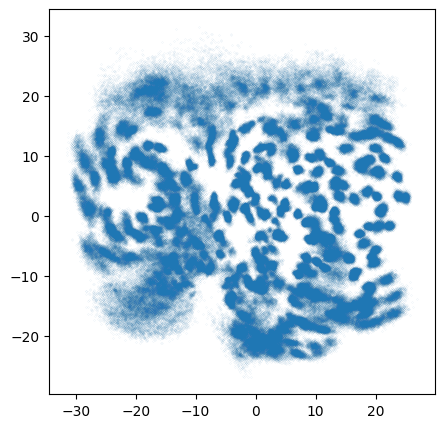

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
fig = plt.scatter(*Xaa[::100, :, :2].reshape((-1, 2)).T , s=.001)

ax.set_aspect('equal')
plt.show()

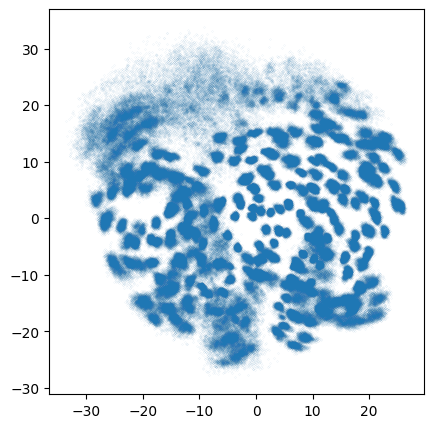

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
fig = plt.scatter(*Xii[::100, :, :2].reshape((-1, 2)).T, s=.001)


ax.set_aspect('equal')
plt.show()

## Calculate RMSDs

In [66]:
rmsd_a_vs_a = Statistics(Xaa).calculate_rmsd(Xaa) 
rmsd_a_vs_i = Statistics(Xaa).calculate_rmsd(Xii) 

rmsd_i_vs_i = Statistics(Xii).calculate_rmsd(Xii) 
rmsd_i_vs_a = Statistics(Xii).calculate_rmsd(Xaa)

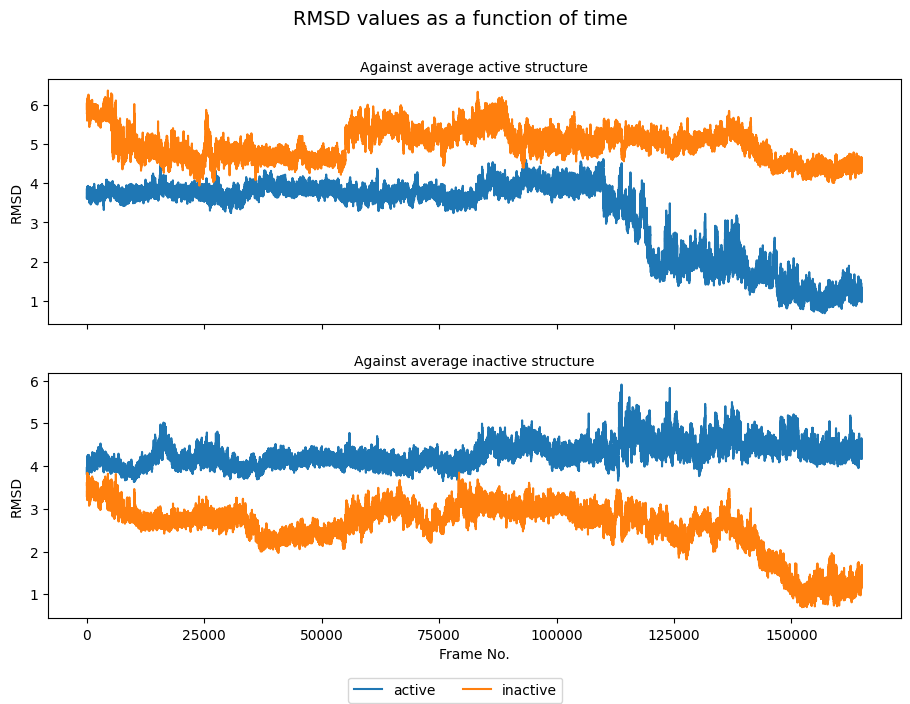

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(11,7))
fig.suptitle('RMSD values as a function of time', fontsize = 14)

ax[0].set_title("Against average active structure", fontsize = 10)
ax[0].plot(np.arange(len(Xaa)), rmsd_a_vs_a, label = 'active')
ax[0].plot(np.arange(len(Xaa)), rmsd_a_vs_i, label = 'inactive')

ax[1].set_title("Against average inactive structure", fontsize = 10)
ax[1].plot(np.arange(len(Xaa)), rmsd_i_vs_a)
ax[1].plot(np.arange(len(Xaa)), rmsd_i_vs_i)



plt.figlegend(  loc = 'lower center', 
              borderaxespad=0.1, 
              ncol=4, 
              labelspacing=0.,  
              prop={'size': 10} )

for ax in fig.get_axes():
    ax.set(xlabel='Frame No.',ylabel= 'RMSD')
    ax.label_outer()
plt.savefig('RMSD_both.png')    
plt.show()

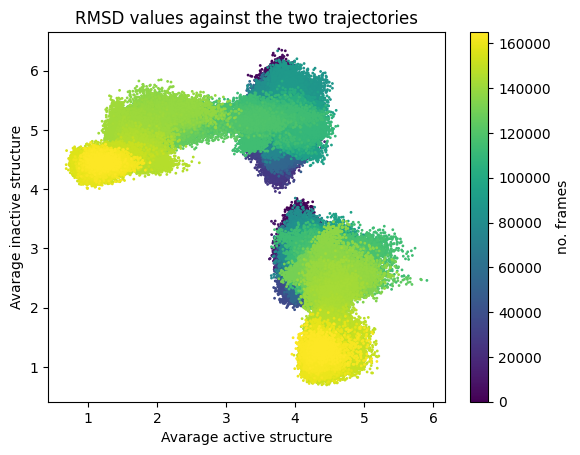

In [70]:
plt.scatter(rmsd_a_vs_a, rmsd_a_vs_i, s=1, c=np.arange(len(Xaa)), label = 'active')
plt.scatter(rmsd_i_vs_a, rmsd_i_vs_i, s=1, c=np.arange(len(Xii)), label = 'inactive')
plt.title('RMSD values against the two trajectories')
plt.xlabel('Avarage active structure')
plt.ylabel('Avarage inactive structure')

cbar = plt.colorbar()
cbar.set_label('no. frames')
plt.savefig('RMSD_against.png')
plt.show()

## Calculate RMSF

In [79]:
rmsf_a = Statistics(Xaa).RMSF()
rmsf_i = Statistics(Xii).RMSF()

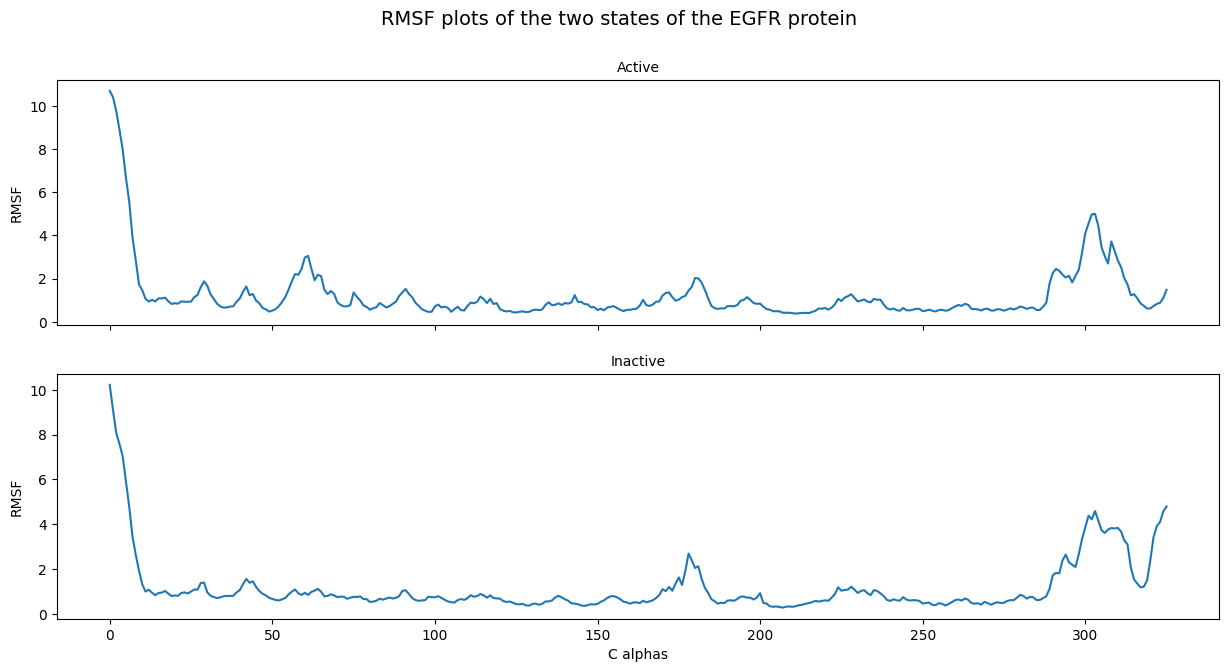

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(15,7))
fig.suptitle('RMSF plots of the two states of the EGFR protein', fontsize = 14)

ax[0].set_title("Active", fontsize = 10)
ax[0].plot(np.arange(len(rmsf_a)), rmsf_a, label = 'active')


ax[1].set_title("Inactive", fontsize = 10)
ax[1].plot(np.arange(len(rmsf_i)), rmsf_i)



for ax in fig.get_axes():
    ax.set(xlabel='C alphas',ylabel= 'RMSF')
    ax.label_outer()
plt.savefig('RMSFs.png')    
plt.show()

## PCA

In [17]:
frames, natoms, dim = Xii.shape

vecXi = Xii.reshape((-1, natoms * dim))
vecXa = Xaa.reshape((-1, natoms * dim))

meanXi = vecXi.mean(axis=0)
meanXa = vecXa.mean(axis=0)

# Combined PCA (all trajectories joined)
# --> includes differential in within system effects

totmean = (meanXi + meanXa) / 2 # Same number of frames

vecXi -= totmean
vecXa -= totmean

cov = (vecXi.T @ (vecXi / (2 * len(Xii)))) + (vecXa.T @ (vecXa / (2 * len(Xaa)))) 
vals, vecs = np.linalg.eigh(cov)

vals = vals[::-1]
vecs = vecs[:, ::-1]

In [24]:
print('Percentage of total variance per eigenvalue:\n', (vals * 100 / np.sum(vals))[:7], '\n')
print('Cumulative sum:\n', (vals.cumsum() * 100 / np.sum(vals))[:7], '\n')

Percentage of total variance per eigenvalue:
 [44.49777149 14.39233991  8.93257183  4.99955883  3.05159887  2.38968165
  2.20333547] 

Cumulative sum:
 [44.49777149 58.8901114  67.82268323 72.82224205 75.87384093 78.26352257
 80.46685805] 



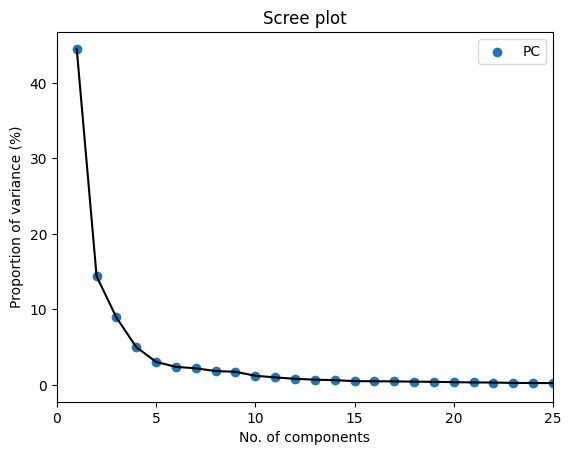

In [36]:
plt.plot(np.arange(len((vals * 100 / np.sum(vals)))) + 1, (vals * 100 / np.sum(vals)), c = 'black')
plt.scatter(np.arange(len((vals * 100 / np.sum(vals)))) + 1, (vals * 100 / np.sum(vals)),  label = 'PC')
plt.title('Scree plot')
plt.ylabel('Proportion of variance (%)')
plt.xlabel('No. of components')
plt.legend()
plt.xlim((0, 25))
plt.savefig('scree_plot.png')
plt.show()

In [34]:
projXi = vecXi @ vecs[:, :5]
projXa = vecXa @ vecs[:, :5]

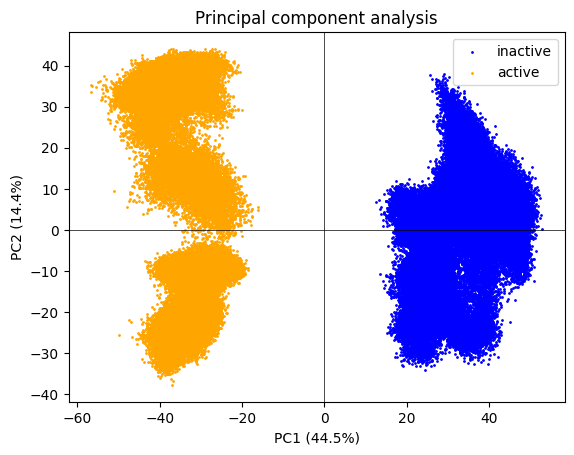

In [35]:
plt.axvline(0, c= 'black', linewidth = 0.5)
plt.axhline(0, c= 'black', linewidth = 0.5)
plt.scatter(*projXi[:, :2].T, s=1, c='blue', label = 'inactive')
plt.scatter(*projXa[:, :2].T, s=1, c='orange', label = 'active')
ax.set_aspect('equal')

plt.title('Principal component analysis')
plt.xlabel('PC1 (44.5%)')
plt.ylabel('PC2 (14.4%)')
plt.legend()
plt.savefig('PCA.png')
plt.show()
